In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.ar_model import AR
import itertools
import warnings
import arch as arch
from arch import arch_model

# Return Forecasting: Read Historical Daily Yen Futures Data

In [2]:
# Read the JPY/USD file and observe file structure
yen_futures = pd.read_csv(Path('yen.csv'), index_col='Date', infer_datetime_format=True,parse_dates=True)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [3]:
yen_futures.tail()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
2019-10-09,9381.0,9391.5,9330.5,9343.5,38.5,9338.0,99153.0,145470.0
2019-10-10,9343.5,9380.5,9293.5,9301.0,34.5,9303.5,159397.0,144474.0
2019-10-11,9308.5,9309.0,9240.0,9267.0,52.5,9251.0,158810.0,147471.0
2019-10-14,9259.0,9292.0,9250.5,9261.0,14.0,9265.0,69457.0,153902.0
2019-10-15,9264.5,9280.0,9216.5,9220.0,43.5,9221.5,108342.0,151564.0


In [4]:
# Trim the dataset to begin on Jan 1st, 1990
yen_futures = yen_futures.loc['1990-01-01':, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


# Perform data cleanup and completeness test

In [5]:
# Check tail() to ensure tail of 2019-10-15 exists in the new dataset
yen_futures.tail()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
2019-10-09,9381.0,9391.5,9330.5,9343.5,38.5,9338.0,99153.0,145470.0
2019-10-10,9343.5,9380.5,9293.5,9301.0,34.5,9303.5,159397.0,144474.0
2019-10-11,9308.5,9309.0,9240.0,9267.0,52.5,9251.0,158810.0,147471.0
2019-10-14,9259.0,9292.0,9250.5,9261.0,14.0,9265.0,69457.0,153902.0
2019-10-15,9264.5,9280.0,9216.5,9220.0,43.5,9221.5,108342.0,151564.0


In [6]:
# Check the data for any Null, NA, NAN
yen_futures.isnull().sum()

Open                             0
High                             0
Low                              0
Last                             0
Change                        6100
Settle                           0
Volume                           0
Previous Day Open Interest       0
dtype: int64

In [7]:
# Remember to drop nulls if change column is required

In [8]:
# Check for duplicate rows; this the only possible column that could logically raise concern when duplicated is the date (index)
# One date cannot appear twice
yen_futures.index.duplicated().sum()

0

In [9]:
# The are no duplicate dates

In [10]:
# Check the size and shape
yen_futures.shape

(7515, 8)

7515 rows by 8 columns

In [11]:
# Size = 7515 * 8 = 60120
yen_futures.size

60120

# Return Forecasting: Initial Time-Series Plotting

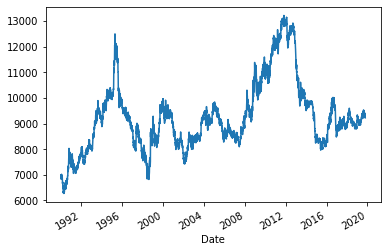

In [12]:
yen_futures.Settle.plot()
plt.show()

Trend: Based on the plot above, we can see a long-term strengthening of the Japanese Yen against the Dollar
There do seem to be some more medium, 1-3 year consistent trends, but on a daily basis, there are a lot of short-term ups and downs.

# Decomposition Using a Hodrick-Prescott Filter

In [13]:
# Using a Hodrick-Prescott Filter, decompose the Settle price into a trend and noise.

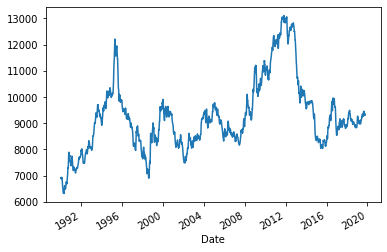

In [14]:
# Calcualte the 10-day moving average
yen_futures.Settle.rolling(window=10).mean().plot()
plt.show()

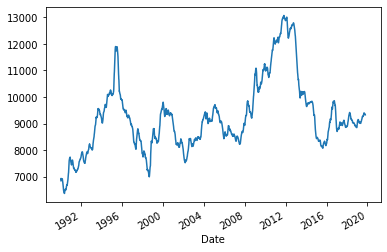

In [15]:
# Calcualte the EWMA - Exponentially Weighted Moving Average
yen_futures.Settle.ewm(halflife=10).mean().plot()
plt.show()

In [16]:
# Apply Hodrick-Prescott filter
import statsmodels.api as sm
ts_noise, ts_trend = sm.tsa.filters.hpfilter(yen_futures.Settle)

In [17]:
# Check the head/tail of trend

In [18]:
ts_trend.head()

Date
1990-01-02    6908.503967
1990-01-03    6908.799756
1990-01-04    6909.057104
1990-01-05    6909.223948
1990-01-08    6909.310062
Name: Settle_trend, dtype: float64

In [19]:
ts_trend.tail()

Date
2019-10-09    9313.060753
2019-10-10    9309.368559
2019-10-11    9305.454594
2019-10-14    9301.423060
2019-10-15    9297.344123
Name: Settle_trend, dtype: float64

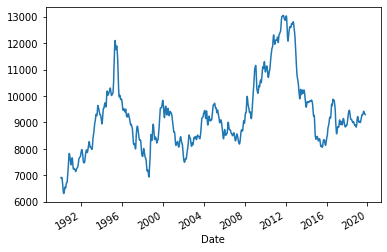

In [20]:
# Plot the trend
ts_trend.plot()
plt.show()

In [21]:
# Check the head/tail of noise

In [22]:
ts_noise.head()

Date
1990-01-02   -61.503967
1990-01-03   -21.799756
1990-01-04    98.942896
1990-01-05    40.776052
1990-01-08    49.689938
Name: Settle_cycle, dtype: float64

In [23]:
ts_noise.tail()

Date
2019-10-09    24.939247
2019-10-10    -5.868559
2019-10-11   -54.454594
2019-10-14   -36.423060
2019-10-15   -75.844123
Name: Settle_cycle, dtype: float64

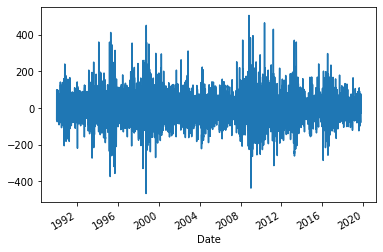

In [24]:
ts_noise.plot()
plt.show()

In [25]:
# Trend and Noise Validation Check
# Initial Time Series(z) = Trend(x) + Noise(y) 
# Sample one data; 2019-10-11

In [26]:
# Initial Time Series for 2019-10-11
z = yen_futures.loc['2019-10-11'].Settle
z

9251.0

In [27]:
# Trend
x = ts_trend.loc['2019-10-11']
x

9305.454593991944

In [28]:
# Noise
y = ts_noise.loc['2019-10-11']
y

-54.45459399194442

In [29]:
z - (x + y)

0.0

In [30]:
yen_futures['trend'] = ts_trend
yen_futures['noise'] = ts_noise
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,trend,noise
Date,,,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0,6908.503967,-61.503967
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0,6908.799756,-21.799756
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0,6909.057104,98.942896
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0,6909.223948,40.776052
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0,6909.310062,49.689938


In [31]:
yen_futures[['Settle', 'trend', 'noise']].head()

,Settle,trend,noise
Date,,,
1990-01-02,6847.0,6908.503967,-61.503967
1990-01-03,6887.0,6908.799756,-21.799756
1990-01-04,7008.0,6909.057104,98.942896
1990-01-05,6950.0,6909.223948,40.776052
1990-01-08,6959.0,6909.310062,49.689938


In [32]:
settle_trend = yen_futures[['Settle', 'trend']]

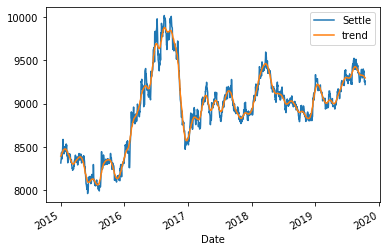

In [33]:
settle_trend.loc['2015-01-01': ].plot()
plt.show()

Smoothing with the HP Filter and plotting the resulting trend against the actual futures returns, we can see that there's a lot of short term fluctuations that deviate around this trend. Perhaps these would represent profitable trading opportunities: For example, when the blue line deviates far below the orange, we can see this as a sign that the Yen is temporarily more undervalued than it should be (and, therefore, we'd see this as a short-term buying opportunity).

In [34]:
settle_noise = yen_futures.noise

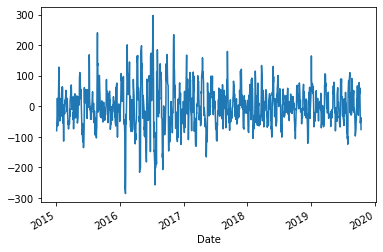

In [35]:
# Reduced Time Series to match Settle v Trend
settle_noise.loc['2015-01-01': ].plot()
plt.show()

Noise for initial time series is already plotted above

# Forecasting Returns using an ARMA Model

Using futures Settle Returns, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

# Test for Stationarity using Returns

In [36]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (yen_futures[["Settle"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Settle
Date,
2019-10-09,-0.410601
2019-10-10,-0.369458
2019-10-11,-0.564304
2019-10-14,0.151335
2019-10-15,-0.469509


In [37]:
returns.head()

,Settle
Date,
1990-01-03,0.584197
1990-01-04,1.756933
1990-01-05,-0.827626
1990-01-08,0.129496
1990-01-09,-0.632275


In [38]:
returns.size

7514

size = 7514 is correct because we dropped the NaN from 1990-01-02

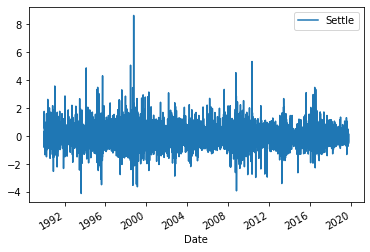

In [39]:
# Plot returns to visualize stationarity or non-stationarity
returns.plot()

Calculate/compare ADF value or t-statistic to the critical value at 95% C.I

In [40]:
x = returns.values
result = adfuller(x)

In [41]:
# computer the minimum ADF value or t-statistic
t_stat = min(result[0:3])
t_stat
print(f'ADF or t-statistic is {t_stat}')

ADF or t-statistic is -87.6773623853942


In [42]:
# Obtain the critical value at 95% level of confidence
critical_val = result[4]['5%']
critical_val
print(f'critical value at 95% level of confidence is {critical_val}')

critical value at 95% level of confidence is -2.8619247816139843


Hypothesis Testing and Decision

In [43]:
if t_stat < critical_val:
    print(f"The T-Statistic or ADF of {t_stat} is less than the Critical Value of {critical_val}")
    #print("The ADF or T-Statistic < Critical Value")
    print("Reject the Null Hypothesis - Reject Ho")
    print("Time Series is Stationary")
else:
    print(f"The T-Statistic or ADF of {t_stat} is greater than the Critical Value of {critical_val}")
    #print("The ADF or T-Statistic > Critical Value")
    print("Accept the Alternate Hypothesis - Accept Ha")
    print("Time Series is Non-Stationary")

The T-Statistic or ADF of -87.6773623853942 is less than the Critical Value of -2.8619247816139843
Reject the Null Hypothesis - Reject Ho
Time Series is Stationary


Determine the MA coordinate by calculating ACF --> MA(0,q)

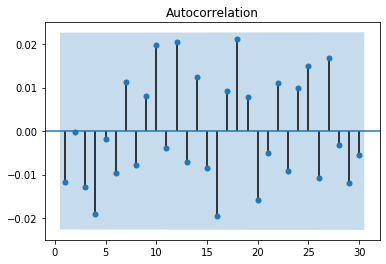

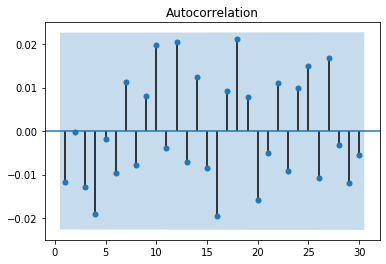

In [44]:
# Plot the ACF of the Difference with a 30 day lag
plot_acf(returns, lags=30, zero=False)

Determine the AR coordinate by calculating PACF --> AR(p,0)

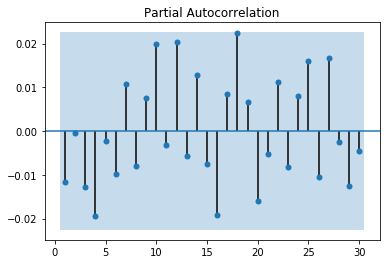

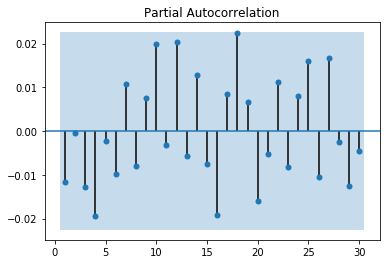

In [45]:
# Plot the PACF of the Difference with a 30 day lag
plot_pacf(returns, lags=30, zero=False)

ARMA(p,q) = ARMA(2,1) Process

In [46]:
model = ARMA(returns.values, order=(2,1))

In [47]:
# Fit the model to the data
results = model.fit()

In [48]:
# Summarize the model
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7514
Model:                     ARMA(2, 1)   Log Likelihood               -7894.071
Method:                       css-mle   S.D. of innovations              0.692
Date:                Thu, 27 Aug 2020   AIC                          15798.142
Time:                        20:49:03   BIC                          15832.765
Sample:                             0   HQIC                         15810.030
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0063      0.008      0.804      0.422      -0.009       0.022
ar.L1.y       -0.3062      1.277     -0.240      0.811      -2.810       2.198
ar.L2.y       -0.0019      0.019     -0.099      0.921      -0.040       0.036
ma.L1.y        0.2946      1.277      0.231      0.818      -2.209       2.798
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -3.3354           +0.0000j            3.3354            0.5000
AR.2         -157.2024           +0.0000j          157.2024            0.5000
MA.1           -3.3944           +0.0000j            3.3944            0.5000
-----------------------------------------------------------------------------
"""

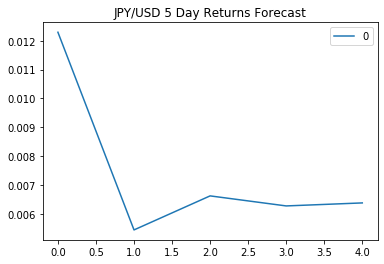

In [49]:
# Plot the forecasted difference for the next 10 days
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="JPY/USD 5 Day Returns Forecast")
plt.show()

The model is not a good fit because all of the p-values at AR1, AR2 and MA1 are greater than alpha (0.05)

# Forecasting the Settle Price using an ARIMA Model

1. Using the raw Yen Settle Price, estimate an ARIMA model. A. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
B. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Construct a 5 day forecast for the Settle Price. What does the model forecast will happen to the Japanese Yen in the near term?

ARIMA(p,d,q) --> AR(p), I(d), MA(q) /
p=5, d=1, q=1 --> ARIMA(5,1,1)

In [50]:
# Estimate and ARIMA Model:
model = ARIMA(yen_futures.Settle, order=(5, 1, 1))

C:\Users\Lance\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Lance\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [51]:
# Fit the model to the data
results = model.fit()

In [52]:
# Summarize the model
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Settle   No. Observations:                 7514
Model:                 ARIMA(5, 1, 1)   Log Likelihood              -41944.619
Method:                       css-mle   S.D. of innovations             64.281
Date:                Thu, 27 Aug 2020   AIC                          83905.238
Time:                        20:49:08   BIC                          83960.635
Sample:                             1   HQIC                         83924.259
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3161      0.700      0.452      0.652      -1.056       1.688
ar.L1.D.Settle     0.2821      0.699      0.403      0.687      -1.088       1.652
ar.L2.D.Settle     0.0007      0.016      0.043      0.966      -0.030       0.032
ar.L3.D.Settle    -0.0127      0.012     -1.032      0.302      -0.037       0.011
ar.L4.D.Settle    -0.0137      0.015     -0.889      0.374      -0.044       0.016
ar.L5.D.Settle    -0.0012      0.018     -0.064      0.949      -0.036       0.034
ma.L1.D.Settle    -0.2971      0.699     -0.425      0.671      -1.667       1.073
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8916           -1.3787j            2.3407           -0.1002
AR.2            1.8916           +1.3787j            2.3407            0.1002
AR.3           -2.2690           -3.0218j            3.7789           -0.3525
AR.4           -2.2690           +3.0218j            3.7789            0.3525
AR.5          -11.0303           -0.0000j           11.0303           -0.5000
MA.1            3.3660           +0.0000j            3.3660            0.0000
-----------------------------------------------------------------------------
"""

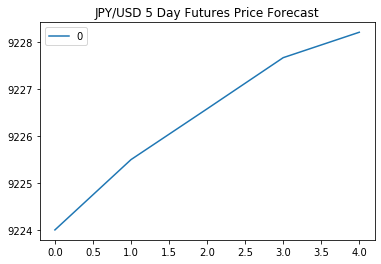

In [53]:
# Visualize the 5 Day forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="JPY/USD 5 Day Futures Price Forecast")
plt.show()

The model is not a good fit because all of the p-values at AR1 to AR5, and MA1 are greater than alpha (0.05)

# Optimizing the ARIMA Model / Minimizing AIC

In [54]:
model_arima = ARIMA(yen_futures.Settle,order=(5,1,1))
model_arima_fit = model_arima.fit()
print(model_arima_fit.aic)

C:\Users\Lance\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Lance\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


83905.23835646757


In [55]:
p=q=range(1,6)
d=range(1,3)
#d=range(0,2)
#p=q=range(0,2)
pdq=list(itertools.product(p,d,q))
pdq

[(1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (1, 1, 4),
 (1, 1, 5),
 (1, 2, 1),
 (1, 2, 2),
 (1, 2, 3),
 (1, 2, 4),
 (1, 2, 5),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (2, 1, 4),
 (2, 1, 5),
 (2, 2, 1),
 (2, 2, 2),
 (2, 2, 3),
 (2, 2, 4),
 (2, 2, 5),
 (3, 1, 1),
 (3, 1, 2),
 (3, 1, 3),
 (3, 1, 4),
 (3, 1, 5),
 (3, 2, 1),
 (3, 2, 2),
 (3, 2, 3),
 (3, 2, 4),
 (3, 2, 5),
 (4, 1, 1),
 (4, 1, 2),
 (4, 1, 3),
 (4, 1, 4),
 (4, 1, 5),
 (4, 2, 1),
 (4, 2, 2),
 (4, 2, 3),
 (4, 2, 4),
 (4, 2, 5),
 (5, 1, 1),
 (5, 1, 2),
 (5, 1, 3),
 (5, 1, 4),
 (5, 1, 5),
 (5, 2, 1),
 (5, 2, 2),
 (5, 2, 3),
 (5, 2, 4),
 (5, 2, 5)]

In [ ]:
warnings.filterwarnings('ignore')
aic_list = []
param_list = []
for param in pdq:
    try:
        #model = ARIMA(passengers_read['NumberPassengers'], order=param)
        model_arima = ARIMA(yen_futures.Settle, order=param)
        model_arima_fit = model_arima.fit()
        #print(param, model_arima_fit.aic)
        #print(f"{param}: {model_arima_fit().aic}")
        aic_list.append(model_arima_fit.aic)
        param_list.append(param)
    except:
        continue

print(f"Minimum AIC is: {min(aic_list)}")
print(f"The index location is at: {aic_list.index(min(aic_list))}")
print(f"The ARIMA Order is: {param_list[aic_list.index(min(aic_list))]}")
print("The ARIMA constraints are: p=q=(1,5) and d=(1,2)")

# Volatility Forecasting with GARCH

In [ ]:
# Estimate a GARCH model:
model = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)

In [ ]:
# Fit the GARCH Model
res = model.fit(disp="off")

In [ ]:
# Summarize the model results
res.summary()

In [ ]:
# Plot the model estimate of annualized volatility
fig = res.plot(annualize='D')

# Forecasting from GARCH

In [ ]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

In [ ]:
# Create a 5 day forecast of volatility
forecast_horizon = 5

In [ ]:
# Start the forecast using the last_day calculated above
forecasts = res.forecast(start='2019-10-15', horizon=forecast_horizon)
forecasts

In [ ]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

In [ ]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

In [ ]:
final.plot()

# Conclusions

Based on your time series analysis, would you buy the yen now?

Is the risk of the yen expected to increase or decrease?

Based on the model evaluation, would you feel confident in using these models for trading?